In [15]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# %matplotlib notebook

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from datetime import datetime

In [3]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [ ]:
df = pd.read_csv('telecom_churn_data.csv')

In [ ]:
print(df.shape)
df.head()

In [ ]:
df.nunique()

### Lets observe the null values

In [ ]:
nul_percentage = round(100*(df.isnull().sum()/len(df.index)),2)

In [ ]:
len(nul_percentage[nul_percentage>70])

* There are more than 40 columns where there is more than 70% of missing data

In [ ]:
df.filter(like = "date", axis =1).columns

* mobile number is unique for each user; lets conver that column to string as there is no valid point to make any analysis on the same.
* several date columns are available.
* After observing the data ,there are some categorical variables also; lets seggregate the same.

In [ ]:
categorical_vars = ["night_pck_user_6", "night_pck_user_7", "night_pck_user_8", 
"night_pck_user_9", "fb_user_6", "fb_user_7", "fb_user_8", "fb_user_9"]

In [ ]:
df[categorical_vars].isnull().sum()

In [ ]:
print(df[categorical_vars].nunique())
for col in categorical_vars:
    print(col, df[col].unique())

* >(>74%) data is missing; As this is a categorical values lets impute the missing value by '-1' as new category and create dummies.

In [ ]:
for col in categorical_vars:
    df[col].fillna(value=-1, inplace=True)

#### Create Dummies for 6,7,8 months; 9th month is not required as its required to analyze the if the user is churned or not?

In [ ]:
df_night_6 = pd.get_dummies(df['night_pck_user_6'],prefix="night_6",drop_first=True)
df_night_7 = pd.get_dummies(df['night_pck_user_7'],prefix="night_7",drop_first=True)
df_night_8 = pd.get_dummies(df['night_pck_user_8'],prefix="night_8",drop_first=True)

df_fb_6 = pd.get_dummies(df['fb_user_6'],prefix="fb_6", drop_first=True)
df_fb_7 = pd.get_dummies(df['fb_user_7'],prefix="fb_7",drop_first=True)
df_fb_8 = pd.get_dummies(df['fb_user_8'],prefix="fb_8",drop_first=True)

telecom = pd.concat([df,df_night_6],axis=1)
telecom = pd.concat([df,df_night_7],axis=1)
telecom = pd.concat([df,df_night_8],axis=1)

telecom = pd.concat([df,df_fb_6],axis=1)
telecom = pd.concat([df,df_fb_7],axis=1)
telecom = pd.concat([df,df_fb_8],axis=1)

In [ ]:
df.drop(labels=categorical_vars, axis=1, inplace=True)

In [ ]:
df.shape

* lets recheck the missing value percentage

In [ ]:
nul_percentage = round(100*(df.isnull().sum()/len(df.index)),2)
print(sorted(nul_percentage, reverse=True))

In [ ]:
nul_percentage[nul_percentage>70]

* > If you observe there are two main columns which are required to calculate the amount of recharge to determine if the user is churned or not. lets impute the missing values for the below columns before proceeding further

* total_rech_data_6           74.85
* total_rech_data_7           74.43
* total_rech_data_8           73.66
* total_rech_data_9           74.08

* av_rech_amt_data_6          74.85
* av_rech_amt_data_7          74.43
* av_rech_amt_data_8          73.66
* av_rech_amt_data_9          74.08

In [ ]:
cols_imp = ["total_rech_data_6", "total_rech_data_7", "total_rech_data_8", "total_rech_data_9", "av_rech_amt_data_6", "av_rech_amt_data_7","av_rech_amt_data_8","av_rech_amt_data_9"]
df[cols_imp].describe().transpose()

In [ ]:
df['total_rech_amt_6'].plot.hist(bins=100)

In [ ]:
for col in cols_imp:
    df[col].fillna(value=0, inplace=True)

In [ ]:
nul_percentage = round(100*(df.isnull().sum()/len(df.index)),2)
print(sorted(nul_percentage, reverse=True))
print('-'*50)
print(nul_percentage[nul_percentage>70])

####  As the missing values for the colums is more than 74%, we can delete the above columns; But date columns can be used to derive new variables; Before deriving the same lets build the churn data for the users based on the below mentioned


1. Analyse the recharge colums and fill missing values for "As mentioned above, you need to predict churn only for the high-value customers. Define high-value customers as follows: Those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase)."
2. Filter high-value customers As mentioned above, you need to predict churn only for the high-value customers. Define high-value customers as follows: Those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase). # total_rech_data_6 # total_rech_data_7 # av_rech_amt_data_6 # av_rech_amt_data_7 

In [ ]:
df['total_data_rech_6'] = df.total_rech_data_6 * df.av_rech_amt_data_6
df['total_data_rech_7'] = df.total_rech_data_7 * df.av_rech_amt_data_7
df['total_data_rech_8'] = df.total_rech_data_8 * df.av_rech_amt_data_8
df['total_data_rech_9'] = df.total_rech_data_9 * df.av_rech_amt_data_9

In [ ]:
df['total_amt_6'] = df.total_rech_amt_6 + df.total_data_rech_6
df['total_amt_7'] = df.total_rech_amt_7 + df.total_data_rech_7
df['total_amt_8'] = df.total_rech_amt_8 + df.total_data_rech_8
df['total_amt_9'] = df.total_rech_amt_9 + df.total_data_rech_9

In [ ]:
cols_to_drop = ['total_rech_data_6', 'total_rech_data_7','total_rech_data_8','total_rech_data_9',
               'av_rech_amt_data_6','av_rech_amt_data_7','av_rech_amt_data_8','av_rech_amt_data_9',
               'total_data_rech_6','total_data_rech_7','total_data_rech_8','total_data_rech_9']
df.drop(labels=cols_to_drop, axis=1, inplace=True)
print(df.shape)

* Filter high-value customers As mentioned above, you need to predict churn only for the high-value customers. Define high-value customers as follows: Those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase). 

In [ ]:
df['av_amt_rech_6_7']=(df.total_amt_6 + df.total_amt_7)/2

In [ ]:
df['av_amt_rech_6_7'].plot.box()

In [ ]:
df['av_amt_rech_6_7'].quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

In [ ]:
avg_amt_rech_2_mon = df['av_amt_rech_6_7'].quantile(0.7)

In [ ]:
filter = (df['av_amt_rech_6_7'] >= avg_amt_rech_2_mon)

In [ ]:
df = df[filter]
print(df.shape)

 *  After filtering the high-value customers, you should get about 29.9k rows3. Tag churners and remove attributes of the churn phase Now tag the churned customers (churn=1, else 0) based on the fourth month as follows: Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase. The attributes you need to use to tag churners are: 
  * total_ic_mou_9 
  * total_og_mou_9 
  * vol_2g_mb_9 
  * vol_3g_mb_9
After tagging churners, remove all the attributes corresponding to the churn phase (all attributes having ‘ _9’, etc. in their names). 
    
* After applying filter we have around 30k rows ( ~ 100 rows extra - Need to check what else missed to take into account )

In [ ]:
df[['total_ic_mou_9','total_og_mou_9','vol_2g_mb_9','vol_3g_mb_9']].describe()

In [ ]:
def isUserChurn(df):
  if(df['total_ic_mou_9'] > 0 or df['total_og_mou_9'] > 0 or df['vol_2g_mb_9'] > 0 or df['vol_3g_mb_9'] > 0):
    return 0
  else:
    return 1

In [ ]:
df['churn'] = df.apply(isUserChurn, axis=1)

In [ ]:
df.shape

In [ ]:
# dropping 9th month cols
cols_to_drop = (list(df.filter(like ='_9', axis =1).columns))

In [ ]:
df.drop(labels=cols_to_drop, axis=1, inplace=True)

In [ ]:
cols_to_drop = list(df.filter(like='sep', axis=1).columns)
print(cols_to_drop)

In [ ]:
df.drop(labels=cols_to_drop, axis=1, inplace=True)

In [ ]:
unique_Values = df.apply(lambda x: x.nunique())
# print(unique_Values)

In [ ]:
unique_Values[unique_Values==1]

In [ ]:
df.info(verbose=1)

In [ ]:
df.shape

#### Convert date columns to Date object and derive new variable

In [ ]:
date_cols = list(df.filter(like='date', axis=1).columns)
print(len(date_cols), date_cols)

<font color=red>Taking some time to run</font>

In [ ]:
for date_col in date_cols:
    df[date_col]=pd.to_datetime(df[date_col])

In [ ]:
df['date_last_rech'] = df[['date_of_last_rech_6', 'date_of_last_rech_7','date_of_last_rech_8']].max(axis=1)

In [ ]:
df[['date_last_rech']].isnull().sum()

In [ ]:
df['date_last_rech_data'] = df[['date_of_last_rech_data_6', 'date_of_last_rech_data_7','date_of_last_rech_data_7']].max(axis=1)

In [ ]:
df['date_last_rech_data'].isnull().sum()

* Now we have date of last recharge; lets convert to days from last recharge; since we are considering only till 8th month(Aug); Need to find the diff from 31 Aug to the column value

In [ ]:
df['days_since_last_recharge'] = df['date_last_rech'].apply(lambda x: datetime(2014, 8, 31) - x)

In [ ]:
df['days_since_last_recharge'] = df['days_since_last_recharge'].apply(lambda x: x.days)

In [ ]:
# df['days_since_last_recharge']

In [ ]:
df['days_since_last_recharge_data'] = df['date_last_rech_data'].apply(lambda x: datetime(2014, 8, 31) - x)

In [ ]:
df['days_since_last_recharge_data'] = df['days_since_last_recharge_data'].apply(lambda x: x.days)

In [ ]:
df['days_since_last_recharge_data'].isnull().sum()

* <font color=green>In case of missing values lets assume user didnt recharged the same. so lets fill the missing values with max value 90 (assuming number of days in 3 months days)</font>

In [ ]:
df['days_since_last_recharge_data'] = df['days_since_last_recharge_data'].fillna(90)

* <font color='green'>Usage includes both data/voice; so lets finalize the days since last recharge as min(voice, data)</font>

In [ ]:
df['days_since_last_rech'] = df[['days_since_last_recharge_data', 'days_since_last_recharge']].min(axis=1)

#### <font color='blue'> New Derived Variable =  days_since_last_rech </font>

* Lets remove all date related columns and intermediate derived variables

In [ ]:
date_cols = list(df.filter(like='date', axis=1).columns)
print(len(date_cols), date_cols)

In [ ]:
df.drop(labels=date_cols, axis=1,inplace=True)

#### Lets clean up the data, where there is no variance explained

In [ ]:
unique_Values = df.apply(lambda x: x.nunique())

In [ ]:
unique_Values[unique_Values==1]

In [ ]:
cols_to_drop = list(unique_Values[unique_Values==1].index)

In [ ]:
df.shape

In [ ]:
len(cols_to_drop)

In [ ]:
df.drop(labels=cols_to_drop,axis=1, inplace=True)

In [ ]:
df.shape

In [ ]:
nul_percentage = round(100*(df.isnull().sum()/len(df.index)),2)
print(sorted(nul_percentage, reverse=True))
print('-'*50)
print(nul_percentage[nul_percentage>40])

In [ ]:
cols_to_drop = nul_percentage[nul_percentage>40].index
print(cols_to_drop, len(cols_to_drop))

In [ ]:
df.shape

In [ ]:
df.drop(labels=cols_to_drop, axis=1, inplace=True)

In [ ]:
df.shape

In [ ]:
nul_percentage = round(100*(df.isnull().sum()/len(df.index)),2)
print(sorted(nul_percentage, reverse=True))

#### rows have all missing values

In [ ]:
print(df.isnull().all(axis=1).sum())

# sum of misisng values in each row
rows_missing_data = df.isnull().sum(axis=1)
rows_missing_data[rows_missing_data > 0]

In [ ]:
rows_missing_data.value_counts()

In [ ]:
rows_missing_data.value_counts(normalize=True)

* Around 4% of data is missing in the data(across the rows), lets remove those rows

### TODO - check if the below step is necessary

In [ ]:
df = (df[df.isnull().sum(axis=1) < 27])

In [ ]:
df.shape

In [ ]:
nul_percentage = round(100*(df.isnull().sum()/len(df.index)),4)
print(sorted(nul_percentage, reverse=True))

In [ ]:
nul_percentage[nul_percentage>0]

In [ ]:
df.isnull().any().any()

* As the number of missing values are less than 4%, lets impute the missing values with 0

In [ ]:
# df.fillna(0, inplace=True)

In [ ]:
print(list(df.columns))

In [ ]:
cols_to_drop = ['days_since_last_recharge', 'days_since_last_recharge_data',
                'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
                'av_amt_rech_6_7']

In [ ]:
df.drop(labels=cols_to_drop, axis=1, inplace=True)

In [ ]:
df[['aon']].describe()

In [ ]:
print(df.aon.min(), df.aon.max())

* AON is represented in days, if we observe the min and max value its 180 and 4321 which is 6 months and 144 months; It means we can represent AON in 6 months buckets.

In [ ]:
df['aon_bin'] = pd.cut(df['aon'], bins=24, include_lowest=False, labels=np.arange(1,25))

In [ ]:
df[['aon','aon_bin']].head(10)

In [ ]:
df.drop(labels='aon', axis=1, inplace=True)

In [ ]:
df['aon_bin'] = df['aon_bin'].astype(int)

In [ ]:
# df.info(verbose=1)

## DataCleaning results

In [ ]:
df.shape

* Initial shape - (99999, 226)
* After cleaning - (28504, 136)

lets save the data frame as cleaned.csv

In [ ]:
df.to_csv('telecom_churn_clean.csv', index=False, sep=',')

In [ ]:
df_churn = pd.read_csv('telecom_churn_clean.csv')

## EDA

In [ ]:
plt.figure(figsize=(30,20))
sns.heatmap(df_churn.corr())

In [ ]:
df_aon = df_churn[['aon_bin', 'churn']]

print(df_aon.head())

df_aon_churn = df_aon[df_aon.churn==1]

df_aon_churn_grp = df_aon_churn.groupby('aon_bin').sum()

print(type(df_aon_churn_grp), df_aon_churn_grp.columns)

df_aon_churn_grp.reset_index(inplace=True)
print(df_aon_churn_grp.head())

%matplotlib inline
sns.barplot(x='aon_bin', y = 'churn', data=df_aon_churn_grp)

* from the above graph we can observe that most of the churns are more till aon_bin is 6(each aon_bin is 6 months), implies 3 years. so till 3 years there are high chances that customer may churn; post 3 years number of churns are less and can assume those who are churn are of other reasons

In [ ]:
# total_amt_6	total_amt_7	total_amt_8-> churn

In [ ]:
# total_amt_6	total_amt_7	total_amt_8 days_since_last_rech
df_amt = df_churn[['total_amt_6','total_amt_7','total_amt_8','days_since_last_rech']]
df_amt_grp = df_amt.groupby('days_since_last_rech').mean()
df_amt_grp.reset_index(inplace=True)
sns.pairplot(df_amt_grp)

In [ ]:
df_arpu = df_churn[['arpu_6','arpu_7','arpu_8','days_since_last_rech']]
# print(df_arpu.head())

df_arpu_grp = df_arpu.groupby(by='days_since_last_rech').sum()

df_arpu_grp.reset_index(inplace=True)

print(df_arpu_grp.columns)

print(df_arpu_grp.head())

sns.pairplot(df_arpu_grp)

## Modelling

In [4]:
df_churn = pd.read_csv('telecom_churn_clean.csv')

In [5]:
# df_churn.equals(df)

In [6]:
df_churn.head()

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,sachet_3g_8,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,total_amt_6,total_amt_7,total_amt_8,churn,days_since_last_rech,aon_bin
0,7000701601,1069.180,1349.850,3171.480,57.84,54.68,52.29,453.43,567.16,325.91,...,0,57.74,19.38,18.74,1580.0,790.0,3638.0,1,5.0,4
1,7001524846,378.721,492.223,137.362,413.69,351.03,35.08,94.66,80.63,136.48,...,0,21.03,910.65,122.16,437.0,955.0,327.0,0,1.0,1
2,7002124215,514.453,597.753,637.760,102.41,132.11,85.14,757.93,896.68,983.39,...,0,0.00,0.00,0.00,600.0,680.0,718.0,0,0.0,4
3,7000887461,74.350,193.897,366.966,48.96,50.66,33.58,85.41,89.36,205.89,...,1,40.45,51.86,0.00,0.0,1166.0,979.0,0,7.0,3
4,7000149764,977.020,2362.833,409.230,0.00,0.00,0.00,0.00,0.00,0.00,...,0,358.10,2706.83,1714.67,6343.0,23230.0,910.0,0,5.0,7


In [7]:
print(df_churn.shape)
df_churn.info(verbose=1)

(28504, 127)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28504 entries, 0 to 28503
Data columns (total 127 columns):
mobile_number           int64
arpu_6                  float64
arpu_7                  float64
arpu_8                  float64
onnet_mou_6             float64
onnet_mou_7             float64
onnet_mou_8             float64
offnet_mou_6            float64
offnet_mou_7            float64
offnet_mou_8            float64
roam_ic_mou_6           float64
roam_ic_mou_7           float64
roam_ic_mou_8           float64
roam_og_mou_6           float64
roam_og_mou_7           float64
roam_og_mou_8           float64
loc_og_t2t_mou_6        float64
loc_og_t2t_mou_7        float64
loc_og_t2t_mou_8        float64
loc_og_t2m_mou_6        float64
loc_og_t2m_mou_7        float64
loc_og_t2m_mou_8        float64
loc_og_t2f_mou_6        float64
loc_og_t2f_mou_7        float64
loc_og_t2f_mou_8        float64
loc_og_t2c_mou_6        float64
loc_og_t2c_mou_7        float64
loc_og_t2c_mou_

* Target Variable - CHURN
* Unique Variable - MOBILE NUMBER
* Rest all - Independent Variable

> Mobile number can be dropped as its a identifier variable

In [8]:
df_churn.drop(labels='mobile_number', axis=1, inplace=True)

In [9]:
X = df_churn.drop(labels='churn', axis=1)
y = df_churn['churn']

In [10]:
X.columns

Index(['arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7',
       'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8',
       'roam_ic_mou_6',
       ...
       'sachet_3g_7', 'sachet_3g_8', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g',
       'total_amt_6', 'total_amt_7', 'total_amt_8', 'days_since_last_rech',
       'aon_bin'],
      dtype='object', length=125)

* lets observe the target variable (churn)

In [11]:
y.value_counts()

0    26908
1     1596
Name: churn, dtype: int64

In [12]:
y.value_counts(normalize=True)

0    0.944008
1    0.055992
Name: churn, dtype: float64

> There is huge imbalance in the target variable; It consists only 5% of the total data

So before applying, PCA and any other classification model, we need to tackle the imbalance of the Target variable
* Here, we are choosing to apply SMOTE(Synthetic Minority Over-sampling Technique) analysis

Modelling Procedure - 
1. Apply StandardScaler
2. Split data for train and test
3. Apply SMOTE
4. Apply PCA
5. Apply LogisticRegression and SVM for classification
6. Compare metrics and decide on the model

In [13]:
# scaler = StandardScaler().fit(X)

# Xscaled = scaler.transform(X)

In [16]:
scaler = StandardScaler()

Xscaled = scaler.fit_transform(X)

In [17]:
Xscaled = pd.DataFrame(Xscaled, index=X.index, columns=X.columns)

In [18]:
Xscaled.columns

Index(['arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7',
       'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8',
       'roam_ic_mou_6',
       ...
       'sachet_3g_7', 'sachet_3g_8', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g',
       'total_amt_6', 'total_amt_7', 'total_amt_8', 'days_since_last_rech',
       'aon_bin'],
      dtype='object', length=125)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(Xscaled,y, train_size=0.7,random_state=42)

In [20]:
print(X_train.shape)
print(X_test.shape)

(19952, 125)
(8552, 125)


In [21]:
print("Train Data Imbalance =\n", y_train.value_counts())
print('-'*50)
print("TEst Data Imbalance =\n",y_test.value_counts())

Train Data Imbalance =
 0    18798
1     1154
Name: churn, dtype: int64
--------------------------------------------------
TEst Data Imbalance =
 0    8110
1     442
Name: churn, dtype: int64


In [22]:
print("Train Data Imbalance =\n", y_train.value_counts(normalize=True)*100)
print('-'*50)
print("TEst Data Imbalance =\n",y_test.value_counts(normalize=True)*100)

Train Data Imbalance =
 0    94.216119
1     5.783881
Name: churn, dtype: float64
--------------------------------------------------
TEst Data Imbalance =
 0    94.831618
1     5.168382
Name: churn, dtype: float64


### Apply SMOTE

In [23]:
sm = SMOTE(random_state=42)

In [24]:
X_train_smote,y_train_smote = sm.fit_sample(X_train,y_train)

In [25]:
print(X_train_smote.shape)
print(y_train_smote.shape)

(37596, 125)
(37596,)


In [26]:
print(len(y_train_smote)-np.count_nonzero(y_train_smote))
print(len(y_train)-np.count_nonzero(y_train))

18798
18798


In [27]:
np.unique(y_train_smote)

array([0, 1], dtype=int64)

In [28]:
print((y_train_smote != 0).sum()/(y_train_smote == 0).sum())

1.0


> After applying SMOTE, we can observe both the classes have same number of samples

### Apply PCA

In [29]:
pca = PCA(random_state=42, svd_solver='randomized')

In [30]:
pca.fit(X_train_smote)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
  svd_solver='randomized', tol=0.0, whiten=False)

In [31]:
pca.components_

array([[ 1.59842820e-01,  1.64297258e-01,  1.23006279e-01, ...,
         1.40640165e-02, -4.29614175e-02, -1.11598538e-02],
       [ 2.62969809e-02,  3.67603722e-02,  7.55588012e-02, ...,
         4.24107804e-02,  6.78202996e-03,  6.91527584e-02],
       [-5.59500962e-03, -2.17248272e-02, -5.37338190e-02, ...,
        -3.53972436e-02,  8.59224048e-03, -6.14624315e-02],
       ...,
       [ 2.01435826e-07,  2.35720055e-07, -1.55311287e-08, ...,
        -7.59360921e-08,  1.57169546e-07, -2.27516458e-07],
       [-2.59684896e-07,  1.71495685e-07, -5.38067388e-08, ...,
        -6.44961218e-08, -1.03317432e-08,  1.82798459e-08],
       [ 3.01394343e-07, -5.77158496e-08,  8.14024038e-08, ...,
         3.82699300e-08,  2.95027364e-08, -8.57724828e-08]])

In [32]:
len(pca.components_)

125

In [33]:
colnames = list(X_train.columns)
pcs_df = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'Feature':colnames})
pcs_df.head()

,Feature,PC1,PC2
0,arpu_6,0.159843,0.026297
1,arpu_7,0.164297,0.036760
2,arpu_8,0.123006,0.075559
3,onnet_mou_6,0.175951,-0.099463
4,onnet_mou_7,0.184929,-0.090089


In [34]:
colnames = list(X_train.columns)
pcs_df1 = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'PC3':pca.components_[2],'Feature':colnames})
pcs_df1.head()

,Feature,PC1,PC2,PC3
0,arpu_6,0.159843,0.026297,-0.005595
1,arpu_7,0.164297,0.036760,-0.021725
2,arpu_8,0.123006,0.075559,-0.053734
3,onnet_mou_6,0.175951,-0.099463,0.018486
4,onnet_mou_7,0.184929,-0.090089,0.006189


In [35]:
pcs_df

,Feature,PC1,PC2
0,arpu_6,0.159843,0.026297
1,arpu_7,0.164297,0.036760
2,arpu_8,0.123006,0.075559
3,onnet_mou_6,0.175951,-0.099463
4,onnet_mou_7,0.184929,-0.090089
5,onnet_mou_8,0.137331,-0.035256
6,offnet_mou_6,0.205924,-0.027702
7,offnet_mou_7,0.214039,-0.019665
8,offnet_mou_8,0.144747,0.022709
9,roam_ic_mou_6,-0.014396,0.036627


In [36]:
# X_train_smote

In [37]:
pca.explained_variance_ratio_.round(3)[:50]

array([0.098, 0.091, 0.077, 0.069, 0.045, 0.043, 0.041, 0.033, 0.026,
       0.023, 0.022, 0.02 , 0.018, 0.018, 0.017, 0.016, 0.015, 0.014,
       0.014, 0.013, 0.012, 0.012, 0.011, 0.01 , 0.009, 0.009, 0.008,
       0.008, 0.008, 0.007, 0.007, 0.007, 0.007, 0.006, 0.006, 0.006,
       0.006, 0.006, 0.006, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005,
       0.004, 0.004, 0.004, 0.004, 0.004])

In [38]:
print(pca.components_)

[[ 1.59842820e-01  1.64297258e-01  1.23006279e-01 ...  1.40640165e-02
  -4.29614175e-02 -1.11598538e-02]
 [ 2.62969809e-02  3.67603722e-02  7.55588012e-02 ...  4.24107804e-02
   6.78202996e-03  6.91527584e-02]
 [-5.59500962e-03 -2.17248272e-02 -5.37338190e-02 ... -3.53972436e-02
   8.59224048e-03 -6.14624315e-02]
 ...
 [ 2.01435826e-07  2.35720055e-07 -1.55311287e-08 ... -7.59360921e-08
   1.57169546e-07 -2.27516458e-07]
 [-2.59684896e-07  1.71495685e-07 -5.38067388e-08 ... -6.44961218e-08
  -1.03317432e-08  1.82798459e-08]
 [ 3.01394343e-07 -5.77158496e-08  8.14024038e-08 ...  3.82699300e-08
   2.95027364e-08 -8.57724828e-08]]


In [39]:
print(pca.explained_variance_)

[1.11113297e+01 1.03359706e+01 8.72122514e+00 7.80652675e+00
 5.08784212e+00 4.81474537e+00 4.58497433e+00 3.74278623e+00
 2.96716033e+00 2.59136786e+00 2.47493804e+00 2.23852255e+00
 2.08269405e+00 1.99021984e+00 1.92731058e+00 1.80917955e+00
 1.71354717e+00 1.60974728e+00 1.53680461e+00 1.45055653e+00
 1.39916251e+00 1.33048526e+00 1.19128675e+00 1.13739665e+00
 1.03385633e+00 1.01064354e+00 9.42258935e-01 8.75792567e-01
 8.58136142e-01 8.31525428e-01 8.06140148e-01 7.87069305e-01
 7.62742262e-01 7.32301199e-01 7.20403685e-01 7.01829291e-01
 7.01238134e-01 6.44621887e-01 6.28936203e-01 6.14518976e-01
 6.04208747e-01 5.79507153e-01 5.75746068e-01 5.57273095e-01
 5.31789912e-01 4.99287061e-01 4.74671926e-01 4.59594674e-01
 4.36813023e-01 4.15100319e-01 4.09399163e-01 3.83871140e-01
 3.59698951e-01 3.54853372e-01 3.41058452e-01 3.25799124e-01
 3.08214371e-01 3.05190444e-01 2.98261745e-01 2.90655374e-01
 2.86491135e-01 2.65856195e-01 2.55765460e-01 2.51982141e-01
 2.46038548e-01 2.334870

In [40]:
# def draw_vector(v0, v1, ax=None):
#     ax = ax or plt.gca()
#     arrowprops=dict(arrowstyle='->',
#                     linewidth=2,
#                     shrinkA=0, shrinkB=0)
#     ax.annotate('', v1, v0, arrowprops=arrowprops)

# # plot data
# plt.scatter(X_train_smote[:, 0], X_train_smote[:, 1], alpha=0.2)
# for length, vector in zip(pca.explained_variance_[:2], pca.components_[:2]):
#     v = vector * 3 * np.sqrt(length)
#     draw_vector(pca.mean_, pca.mean_ + v)
# plt.axis('equal');

In [41]:
np.cumsum(pca.explained_variance_ratio_[:100])

array([0.09817997, 0.18950886, 0.26656981, 0.33554846, 0.38050476,
       0.42304796, 0.4635609 , 0.49663225, 0.52285015, 0.54574754,
       0.56761615, 0.58739579, 0.60579852, 0.62338415, 0.64041392,
       0.65639987, 0.67154081, 0.68576458, 0.69934382, 0.71216097,
       0.724524  , 0.7362802 , 0.74680644, 0.75685651, 0.76599169,
       0.77492176, 0.78324758, 0.7909861 , 0.79856861, 0.80591599,
       0.81303907, 0.81999363, 0.82673324, 0.83320387, 0.83956937,
       0.84577075, 0.85196691, 0.8576628 , 0.8632201 , 0.86865   ,
       0.87398881, 0.87910934, 0.88419665, 0.88912073, 0.89381964,
       0.89823135, 0.90242556, 0.90648655, 0.91034624, 0.91401408,
       0.91763154, 0.92102343, 0.92420174, 0.92733723, 0.93035083,
       0.9332296 , 0.93595299, 0.93864966, 0.94128511, 0.94385335,
       0.94638479, 0.9487339 , 0.95099385, 0.95322037, 0.95539438,
       0.95745747, 0.9594754 , 0.96146891, 0.96338487, 0.96516256,
       0.9669286 , 0.9686739 , 0.97036974, 0.97203764, 0.97367

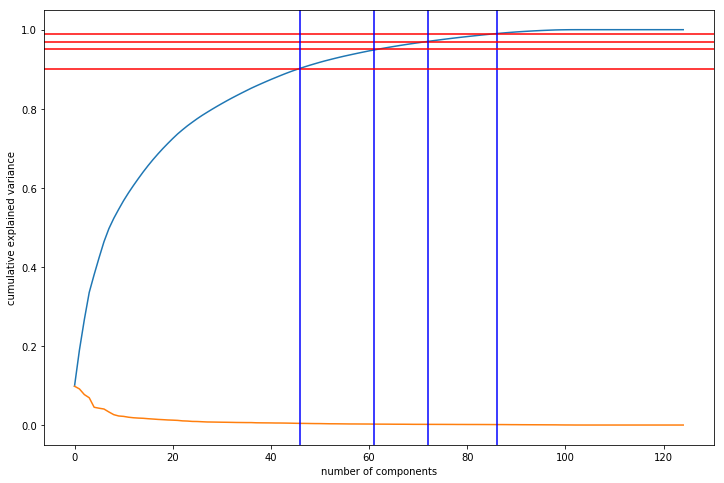

In [42]:
#Making the screeplot - plotting the cumulative variance against the number of components
%matplotlib inline
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axhline(y=.99, color='r', linestyle='-')
plt.axvline(x=86, color='b', linestyle='-')
plt.axhline(y=.97, color='r', linestyle='-')
plt.axvline(x=72, color='b', linestyle='-')
plt.axhline(y=.95, color='r', linestyle='-')
plt.axvline(x=61, color='b', linestyle='-')
plt.axhline(y=.90, color='r', linestyle='-')
plt.axvline(x=46, color='b', linestyle='-')
plt.show()

> from the above plot, to explain the 
* Variance - Num Of Features
* 99-86
* 97-92
* 95-61
* 90-46

<font color='green'>lets choose 90% variance and lets proceed to Create a Incremental PCA with 61 features</font>

In [ ]:
# pca_inc = IncrementalPCA(n_components=61)
# pca_inc_90 = IncrementalPCA(n_components=46)
# pca_inc_99 = IncrementalPCA(n_components=86)

In [ ]:
# df_train_pca = pca_inc.fit_transform(X_train_smote)
# print(df_train_pca.shape)
# print('-'*50)
# df_test_pca = pca_inc.fit_transform(X_test)
# print(df_test_pca.shape)

In [ ]:
# df_train_pca_99 = pca_inc_99.fit_transform(X_train_smote)
# print(df_train_pca_99.shape)
# print('-'*50)
# df_test_pca_99 = pca_inc_99.fit_transform(X_test)
# print(df_test_pca_99.shape)

In [ ]:
# df_train_pca_99 = pca_inc_99.fit_transform(X_train_smote)
# print(df_train_pca_99.shape)
# print('-'*50)
# df_test_pca_99 = pca_inc_99.fit_transform(X_test)
# print(df_test_pca_99.shape)

In [ ]:
# %matplotlib inline
# plt.figure(figsize = (20,10))
# sns.heatmap(corrmat,annot = True)

In [ ]:
# #creating correlation matrix for the principal components
# corrmat = np.corrcoef(df_train_pca.transpose())
# corrmat_nodiag = corrmat - np.diagflat(corrmat.diagonal())
# print("max corr:",corrmat_nodiag.max(), ", min corr: ", corrmat_nodiag.min())

### Apply Logit

In [43]:
pca_995 = PCA(0.995)

df_train_pca_995 = pca_995.fit_transform(X_train_smote)
print("Train shape - ", df_train_pca_995.shape)

df_test_pca_995 = pca_995.transform(X_test)
print("Test shape - ", df_test_pca_995.shape)

Train shape -  (37596, 92)
Test shape -  (8552, 92)


In [82]:
learner_pca_995 = LogisticRegression(class_weight='balanced')
model_pca_995 = learner_pca_995.fit(df_train_pca_995,y_train_smote)

In [83]:
#Making prediction on the test data
pred_probs_995 = model_pca_995.predict_proba(df_test_pca_995)[:,1]
print("{:2.2f}".format(metrics.roc_auc_score(y_test, pred_probs_995)))

y_pred_995 = model_pca_995.predict(df_test_pca_995)
print(metrics.confusion_matrix(y_test, y_pred_995))

# print other metrics

# accuracy
print("accuracy - ", metrics.accuracy_score(y_test, y_pred_995))

# precision
print("precision - ", metrics.precision_score(y_test, y_pred_995))

# recall/sensitivity
print("recall/sensitivity - ", metrics.recall_score(y_test, y_pred_995))

0.88
[[6620 1490]
 [  76  366]]
accuracy -  0.8168849391955099
precision -  0.19719827586206898
recall/sensitivity -  0.8280542986425339


In [ ]:
# metrics.precision_recall_curve(y_test, pred_probs_995)

In [ ]:
# metrics.roc_curve(y_test, y_pred_995)

In [ ]:
# metrics.accuracy_score(y_test,y_pred_995)

In [47]:
pca_99 = PCA(0.99)

df_train_pca_99 = pca_99.fit_transform(X_train_smote)
print("train shape = ", df_train_pca_99.shape)

df_test_pca_99 = pca_99.transform(X_test)
print("test shape = ", df_test_pca_99.shape)

train shape =  (37596, 87)
test shape =  (8552, 87)


In [48]:
learner_pca_99 = LogisticRegression()
model_pca_99 = learner_pca_99.fit(df_train_pca_99, y_train_smote)

In [49]:
# Making prediction on the test data
# pred_probs_test_99 = model_pca1.predict_proba(df_test_pca_99)[:,1]
# print("{:2.2f}".format(metrics.roc_auc_score(y_test, pred_probs_test_99)))

In [50]:
#Making prediction on the test data
pred_probs_test_99 = model_pca_99.predict_proba(df_test_pca_99)[:,1]
print("AUC Score = ", "{:2.2f}".format(metrics.roc_auc_score(y_test, pred_probs_test_99)))

y_pred_99 = model_pca_99.predict(df_test_pca_99)
print("Confusoin Matrix - \n", metrics.confusion_matrix(y_test, y_pred_99))

# print other metrics

# accuracy
print("accuracy - ", metrics.accuracy_score(y_test, y_pred_99))

# precision
print("precision - ", metrics.precision_score(y_test, y_pred_99))

# recall/sensitivity
print("recall/sensitivity - ", metrics.recall_score(y_test, y_pred_99))

AUC Score =  0.88
Confusoin Matrix - 
 [[6631 1479]
 [  73  369]]
accuracy -  0.8185219831618334
precision -  0.19967532467532467
recall/sensitivity -  0.834841628959276


In [51]:
pca_95 = PCA(0.95)

df_train_pca_95 = pca_95.fit_transform(X_train_smote)
print("train shape = ", df_train_pca_95.shape)

df_test_pca_95 = pca_95.transform(X_test)
print("test shape = ", df_test_pca_95.shape)

train shape =  (37596, 63)
test shape =  (8552, 63)


In [78]:
learner_pca_95 = LogisticRegression(class_weight='balanced')
model_pca_95 = learner_pca_95.fit(df_train_pca_95, y_train_smote)

In [79]:
#Making prediction on the test data
pred_probs_test_95 = model_pca_95.predict_proba(df_test_pca_95)[:,1]
print("{:2.2f}".format(metrics.roc_auc_score(y_test, pred_probs_test_95)))

y_pred_95 = model_pca_95.predict(df_test_pca_95)
print(metrics.confusion_matrix(y_test, y_pred_95))

# print other metrics

# accuracy
print("accuracy - ", metrics.accuracy_score(y_test, y_pred_95))

# precision
print("precision - ", metrics.precision_score(y_test, y_pred_95))

# recall/sensitivity
print("recall/sensitivity - ", metrics.recall_score(y_test, y_pred_95))

0.88
[[6596 1514]
 [  75  367]]
accuracy -  0.8141955098222639
precision -  0.1951089845826688
recall/sensitivity -  0.830316742081448


In [80]:
confusion_mat_lr_95 = metrics.confusion_matrix(y_test, y_pred_95)
TN = confusion_mat_lr_95[0, 0]
FP = confusion_mat_lr_95[0, 1]
FN = confusion_mat_lr_95[1, 0]
TP = confusion_mat_lr_95[1, 1]

sensitivity_svm = TP / float(FN + TP)
print("sensitivity_svm",sensitivity_svm)

sensitivity_svm 0.830316742081448


In [54]:
pca_90 = PCA(0.90)

df_train_pca_90 = pca_90.fit_transform(X_train_smote)
print("train shape = ", df_train_pca_90.shape)

df_test_pca_90 = pca_90.transform(X_test)
print("test shape = ", df_test_pca_90.shape)

corrmat = np.corrcoef(df_train_pca_90.transpose())
corrmat_nodiag = corrmat - np.diagflat(corrmat.diagonal())
print("max corr:",corrmat_nodiag.max(), ", min corr: ", corrmat_nodiag.min())

train shape =  (37596, 47)
test shape =  (8552, 47)
max corr: 1.3862381154125827e-15 , min corr:  -1.0503132082515848e-15


In [76]:
learner_pca_90 = LogisticRegression(class_weight='balanced')
model_pca_90 = learner_pca_90.fit(df_train_pca_90, y_train_smote)

In [77]:
#Making prediction on the test data
pred_probs_test_90 = model_pca_90.predict_proba(df_test_pca_90)[:,1]
print("AUC Score = ", "{:2.2f}".format(metrics.roc_auc_score(y_test, pred_probs_test_90)))

y_pred_90 = model_pca_90.predict(df_test_pca_90)
print("Confusoin Matrix - \n", metrics.confusion_matrix(y_test, y_pred_90))

# print other metrics

# accuracy
print("accuracy - ", metrics.accuracy_score(y_test, y_pred_90))

# precision
print("precision - ", metrics.precision_score(y_test, y_pred_90))

# recall/sensitivity
print("recall/sensitivity - ", metrics.recall_score(y_test, y_pred_90))

AUC Score =  0.88
Confusoin Matrix - 
 [[6544 1566]
 [  79  363]]
accuracy -  0.8076473339569691
precision -  0.18818040435458788
recall/sensitivity -  0.8212669683257918


In [ ]:
# confusion = metrics.confusion_matrix(y_test, y_pred_90)
# confusion

In [ ]:
# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

In [ ]:
# # positive predictive value 
# print (TP / float(TP+FP))

In [ ]:
# # Negative predictive value
# print (TN / float(TN+ FN))

In [57]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return fpr, tpr, thresholds

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_95, drop_intermediate = False)

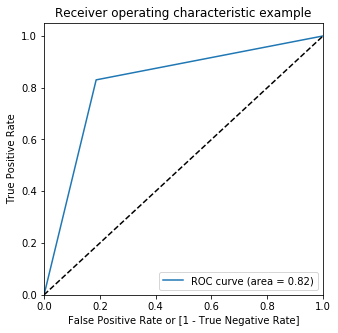

(array([0.        , 0.18668311, 1.        ]),
 array([0.        , 0.83031674, 1.        ]),
 array([2, 1, 0], dtype=int64))

In [58]:
draw_roc(y_test, y_pred_95)

* with probability cut-off at ~0.6, accuracy >81 can be achieved

In [ ]:
# y_train_pred_final = pd.DataFrame({'Churn':y_pred_90, 'Churn_Prob':pred_probs_test_90})

In [ ]:
# # Let's create columns with different probability cutoffs 
# numbers = [float(x)/10 for x in range(10)]
# for i in numbers:
#     y_train_pred_final[i]= y_pred_90.Churn_Prob.map(lambda x: 1 if x > i else 0)
# y_train_pred_final.head()

### Apply SVM

In [59]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [63]:
folds = KFold(n_splits = 3, shuffle = True, random_state = 42)

# specify range of parameters (C) as a list
params = {"C": [0.1, 1, 10, 100, 1000]}

# handling class imbalance in model
model = SVC(class_weight='balanced')

# set up grid search scheme
# note that we are still using the 5 fold CV scheme we set up earlier
model_pca_svm = GridSearchCV(estimator = model, 
                             param_grid = params, 
                             scoring= 'recall', 
                             cv = folds, 
                             verbose = 1,
                             return_train_score=True,n_jobs=-1)

In [64]:
# fit the model
model_pca_svm.fit(df_train_pca_95, y_train_smote)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  6.0min finished


GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
       error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.1, 1, 10, 100, 1000]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring='recall', verbose=1)

In [65]:
print("Test")

Test


In [66]:
# cv results
cv_results = pd.DataFrame(model_pca_svm.cv_results_)
cv_results

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_C,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,114.881042,28.302885,0.842121,0.850469,0.1,{'C': 0.1},5,0.835914,0.848719,0.842013,0.85520,0.848436,0.847489,4.508724,0.766342,0.005113,0.003383
1,110.515387,22.176034,0.953408,0.961725,1,{'C': 1},4,0.950200,0.962738,0.952366,0.96160,0.957658,0.960837,4.837937,0.411628,0.003133,0.000781
2,136.085740,11.750106,0.991117,0.996222,10,{'C': 10},3,0.988029,0.994814,0.992220,0.99624,0.993103,0.997612,15.053763,0.852541,0.002214,0.001142
3,126.977249,6.574138,0.995373,1.000000,100,{'C': 100},1,0.995052,1.000000,0.995078,1.00000,0.995990,1.000000,10.835558,0.249342,0.000436,0.000000
4,133.298943,4.197723,0.993724,1.000000,1000,{'C': 1000},2,0.993136,1.000000,0.993490,1.00000,0.994547,1.000000,3.916776,0.850795,0.000599,0.000000


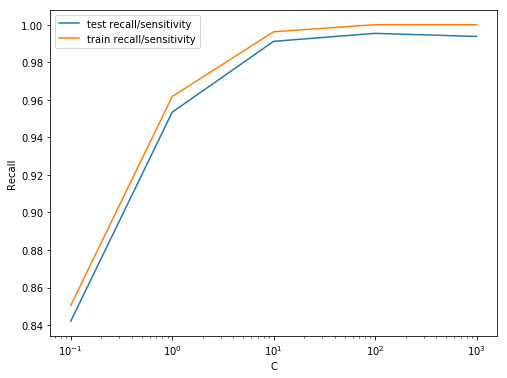

In [67]:
# plot of C versus train and test scores

plt.figure(figsize=(8, 6))
plt.plot(cv_results['param_C'], cv_results['mean_test_score'])
plt.plot(cv_results['param_C'], cv_results['mean_train_score'])
plt.xlabel('C')
plt.ylabel('Recall')
plt.legend(['test recall/sensitivity', 'train recall/sensitivity'], loc='upper left')
plt.xscale('log')

In [68]:
# printing the optimal accuracy score and hyperparameters
best_score = model_pca_svm.best_score_
best_C = model_pca_svm.best_params_['C']

print(" The highest test recall is {0} at C = {1}".format(best_score, best_C))

 The highest test recall is 0.9953733516267836 at C = 100


* Build the model with best hyper parameters

In [69]:
# model with the best value of C
svm_model = SVC(C=best_C, class_weight='balanced')

# fit
svm_model.fit(df_train_pca_95, y_train_smote)

# predict
y_pred = svm_model.predict(df_test_pca_95)

In [81]:
# metrics
# print other metrics

# accuracy
print("accuracy", metrics.accuracy_score(y_test, y_pred))

# precision
print("precision", metrics.precision_score(y_test, y_pred))

# recall/sensitivity
print("recall/sensitivity", metrics.recall_score(y_test, y_pred))


accuracy 0.9242282507015903
precision 0.29961089494163423
recall/sensitivity 0.34841628959276016


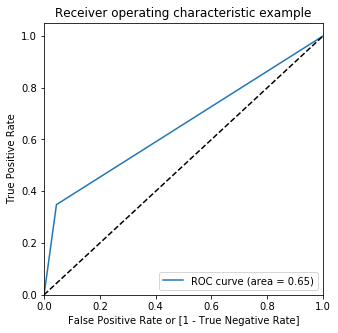

(array([0.        , 0.04438964, 1.        ]),
 array([0.        , 0.34841629, 1.        ]),
 array([2, 1, 0], dtype=int64))

In [74]:
draw_roc(y_test, y_pred)